# Long Notebook - Active

#### Emil B. Berglund - 529222 & Louis H. H. Linnerud - 539305, Team: Noe Lættis 

#### Table of contents:
1. Exploratory data analysis
2. Feature Engineering 
3. Models/Predictors
    - LightGBM
    - Random Forest Regressor
4. Model Interpretations
    - feature importance
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
import featuretools as ft
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder


#from pandas_profiling import ProfileReport

/Users/louislinnerud/Documents/skole/3.klasse/5.semester/MachineLearning/CodeFolder2/MachineLearning-TDT4173-Project/MLvenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [3]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


### EDA Notes
- [x] Search domain knowledge
- [x] Check if the data is intuitive
- [ ] Understand how the data was generated
- [x] Explore individual features
    - [x] Agencies
    - [x] stores with 0 revenue
    - [x] food and drink stores and grovery stores
- [x] Explore pairs and groups
    - [x] Store type vs revenue
    - [x] Geo position of stores in train and test set
    - [x] Revenue based on geo position
- [x] Clean up features
    - [x] remove 2016
    - [x] remove outliers
    - [x] remove 0 revenue rows


#### Domain Knowledge

Retailers obviously earn their revenue from sales, different retailers sell different products to different customers. Different products have different margins and number of sales, directly impacting the revenue. Number of sales most likely have a high correlation with number of costumers, areas with a high population density will therefor most likely have a higher number of customers, impacting number of sales and then impacting the revenue. Therefor retailer type and geographical position most likely have a high impact on revenue. Only knowing those two attributes can be a good pin pointer, but not necessary enough as described in this article: https://carto.com/blog/retail-revenue-prediction-data-science/. Area infrastructure, retailer reputation, market competition, inventory managements, customer type, sales strategy and a lot more factors impact revenue and makes this problem complex. further reading on some of these factors: https://smallbusiness.chron.com/calculate-percentage-profit-markups-business-60099.html


#### Is the data intuitiv?

As can be seen below, data is organized in rows, where each row represents a single retailer with its relevant attributes and revenue. The stores train, extra and test data is intuitiv.

The different grunnkrets data was not super intuitv before some exploration was done, the same grunnkrets_id appeard more than once, but we shortly realized that this is because the measurment (example: average income) is done twice, once in 2015 and once in 2016.

In [4]:
stores_train = pd.read_csv('data/stores_train.csv')


In [5]:
stores_train.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

In [6]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [7]:
stores_train.describe()

year  grunnkrets_id           lat           lon       revenue
count  12859.0   1.285900e+04  12859.000000  12859.000000  12859.000000
mean    2016.0   9.338697e+06     61.212166      9.995425      8.220683
std        0.0   5.788875e+06      2.965672      3.793565     15.377130
min     2016.0   1.010105e+06     57.994443      4.625889      0.000000
25%     2016.0   3.014208e+06     59.421935      7.284691      1.195000
50%     2016.0   9.065213e+06     59.939017     10.407916      3.374000
75%     2016.0   1.449011e+07     62.116531     10.848180      7.996000
max     2016.0   2.030031e+07     71.098287     31.118935    219.599000

In [8]:
#report = ProfileReport(stores_train)
#report

#### Explore individual features and pairs and groups

Explore revenue based on store type

In [9]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

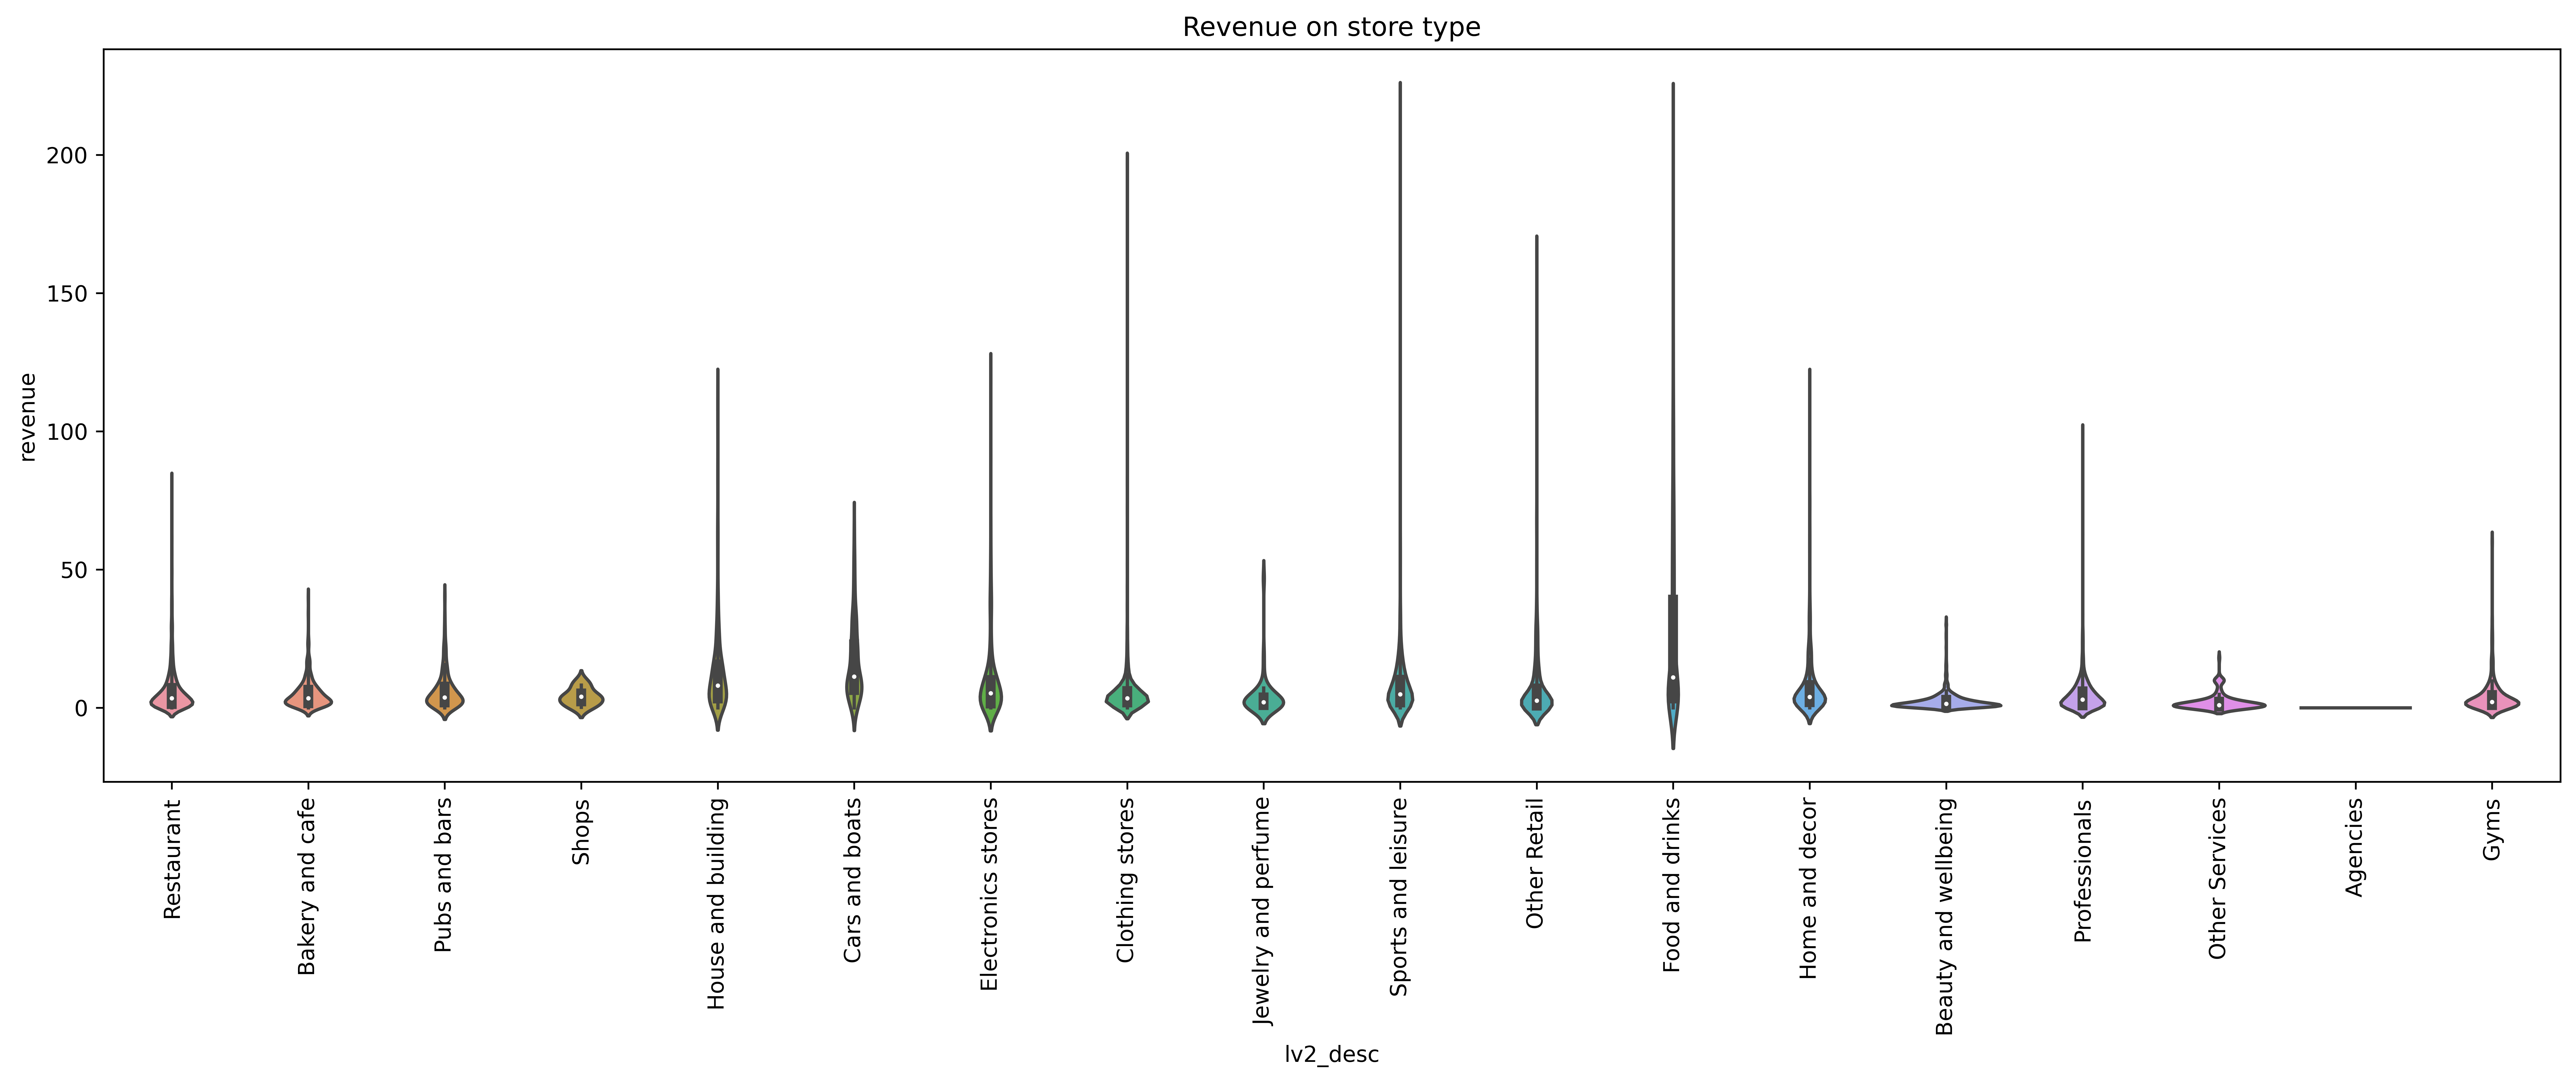

In [10]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [11]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

store_id  year                     store_name  \
12442  915797512-915815782-782390  2016  RUUKKI BUILDING COMPONENTS AS   

      plaace_hierarchy_id  sales_channel_name_x  grunnkrets_id  \
12442             3.5.3.0  Advertising agencies        3014005   

                  address        lat        lon chain_name  ... revenue  \
12442  ØSTRE AKER VEI 219  59.948112  10.883745        NaN  ...     0.0   

       sales_channel_name_y lv1  lv1_desc  lv2  lv2_desc    lv3  \
12442  Advertising agencies   3  Services  3.5  Agencies  3.5.3   

                   lv3_desc      lv4              lv4_desc  
12442  Advertising agencies  3.5.3.0  Advertising agencies  

[1 rows x 21 columns]

Further exploration of "Food and drink" type stores


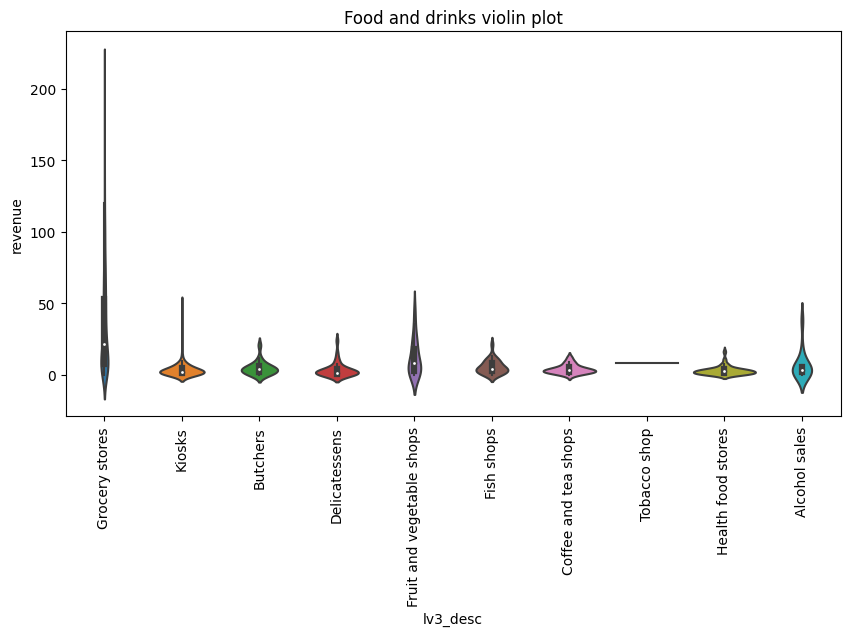

In [12]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with NaN, 0 or negative revenue

In [13]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

year  grunnkrets_id         lat         lon  revenue         lv1  \
count   217.0   2.170000e+02  217.000000  217.000000    217.0  217.000000   
mean   2016.0   7.609318e+06   60.671650   10.007769      0.0    1.788018   
std       0.0   5.511516e+06    2.432534    3.006842      0.0    0.594141   
min    2016.0   1.040301e+06   58.029041    5.035586      0.0    1.000000   
25%    2016.0   3.010401e+06   59.559941    8.591472      0.0    1.000000   
50%    2016.0   6.020802e+06   59.919065   10.620743      0.0    2.000000   
75%    2016.0   1.201012e+07   60.394286   10.814440      0.0    2.000000   
max    2016.0   2.030030e+07   69.890997   30.043801      0.0    3.000000   

              lv2  
count  217.000000  
mean     2.188940  
std      0.758634  
min      1.100000  
25%      1.100000  
50%      2.400000  
75%      2.800000  
max      3.600000

In [14]:
stores_with_hierarchy[stores_with_hierarchy["revenue"] < 0.0].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

In [15]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]== np.nan].describe()

year  grunnkrets_id  lat  lon  revenue  lv1  lv2
count   0.0            0.0  0.0  0.0      0.0  0.0  0.0
mean    NaN            NaN  NaN  NaN      NaN  NaN  NaN
std     NaN            NaN  NaN  NaN      NaN  NaN  NaN
min     NaN            NaN  NaN  NaN      NaN  NaN  NaN
25%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
50%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
75%     NaN            NaN  NaN  NaN      NaN  NaN  NaN
max     NaN            NaN  NaN  NaN      NaN  NaN  NaN

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the plots below

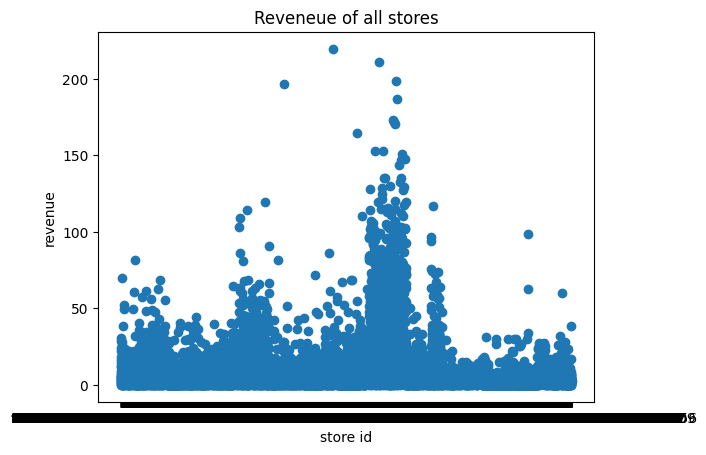

<Figure size 3000x500 with 0 Axes>

In [16]:
plt.plot(stores_train['store_id'], stores_train['revenue'],'o')
plt.title("Reveneue of all stores")
plt.xlabel("store id")
plt.ylabel("revenue")
plt.figure(figsize=(30,5))
plt.show()

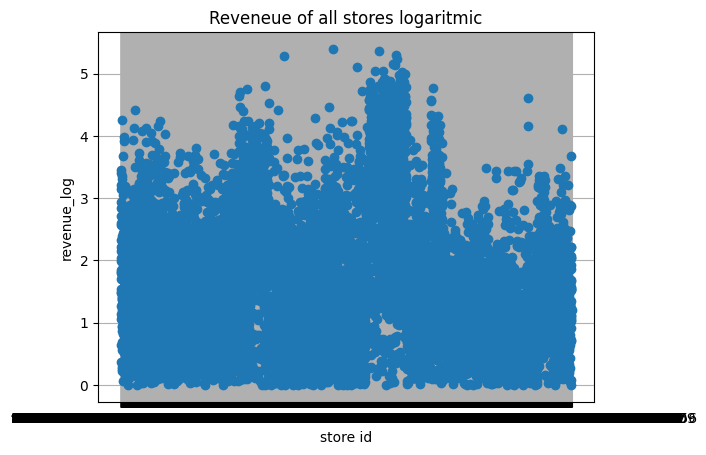

In [17]:
rev_log = pd.DataFrame()
rev_log['revenue'] = stores_train['revenue']
rev_log[rev_log['revenue']==0] = np.mean(rev_log['revenue'])
rev_log['revenue'] = np.log1p(rev_log['revenue'])

plt.plot(stores_train['store_id'],rev_log['revenue'],'o')
plt.title("Reveneue of all stores logaritmic")
plt.xlabel("store id")
plt.ylabel("revenue_log")
plt.grid()
plt.show()

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [18]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [19]:
remove_columns(stores_train,['year'])
stores_train.head()

store_id                           store_name  \
0   983540538-974187930-44774  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

#### Remove retailers with 0 revenue function - might be handy

In [20]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

Below is before trimming

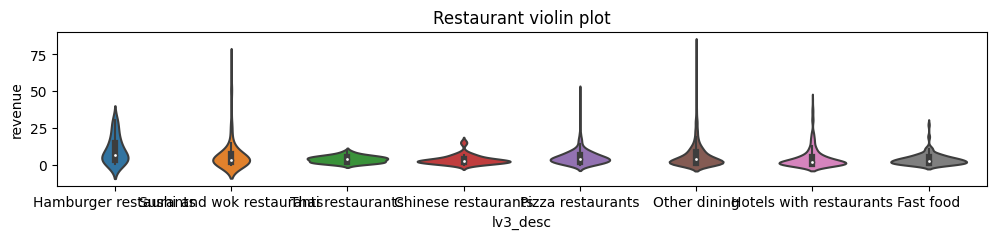

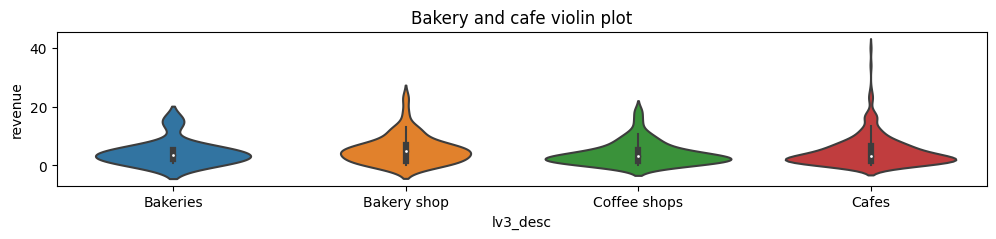

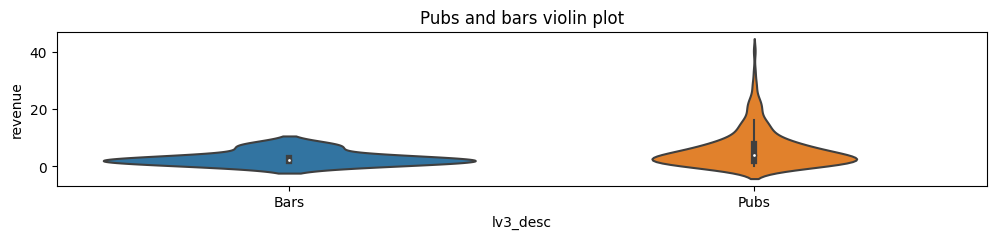

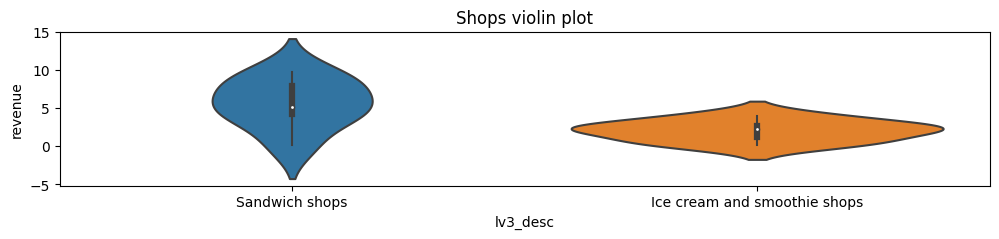

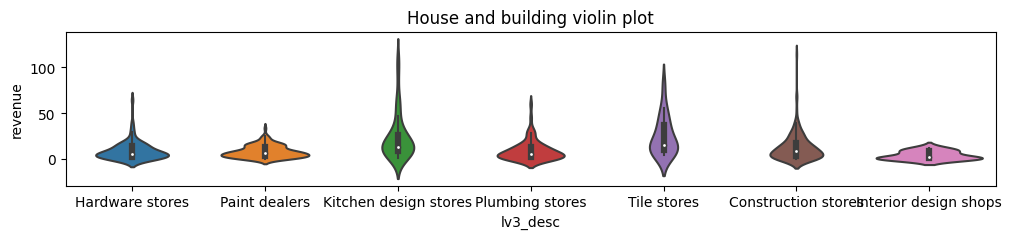

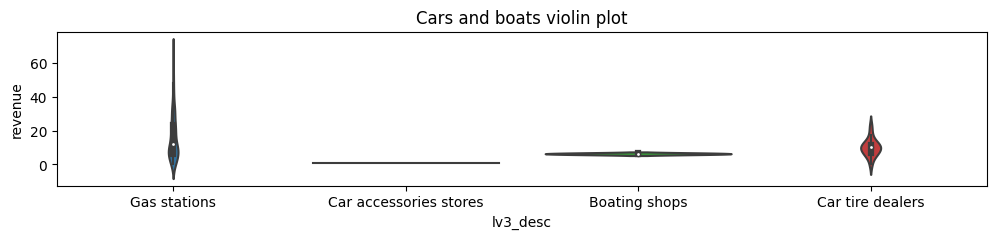

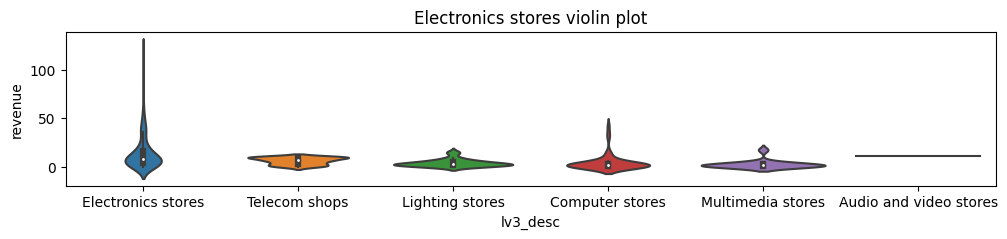

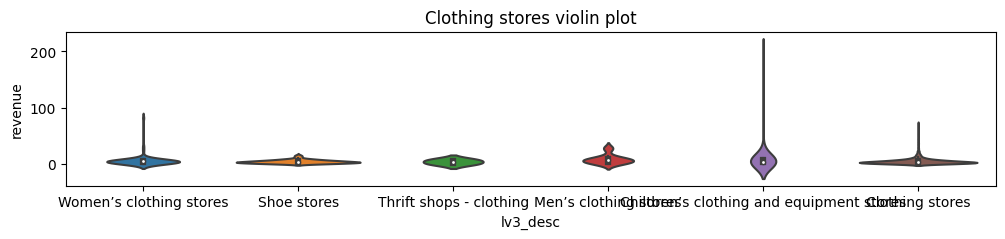

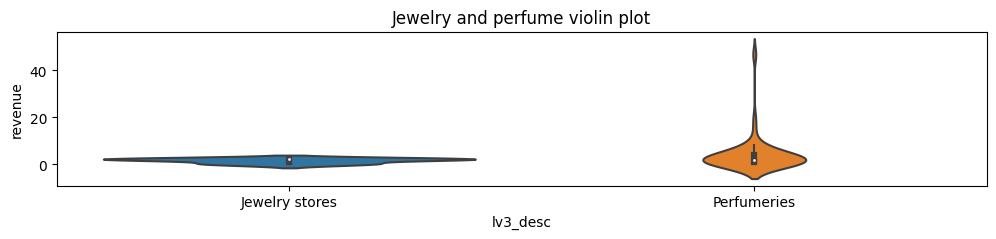

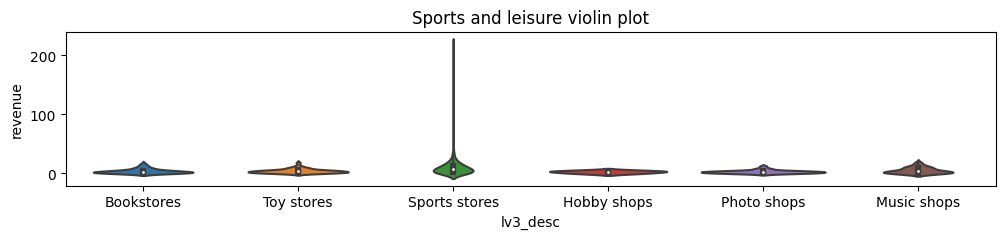

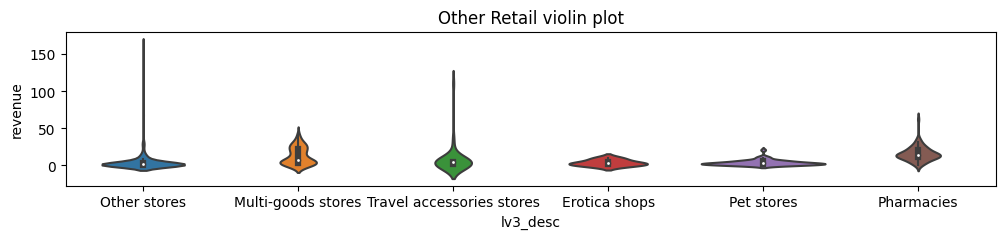

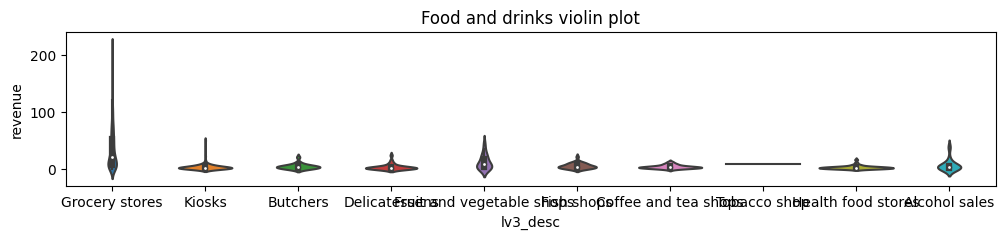

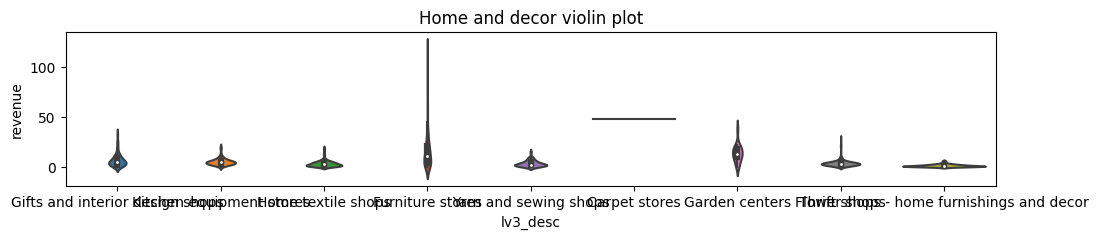

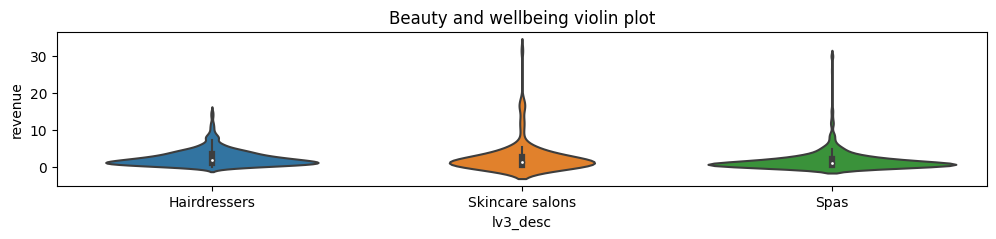

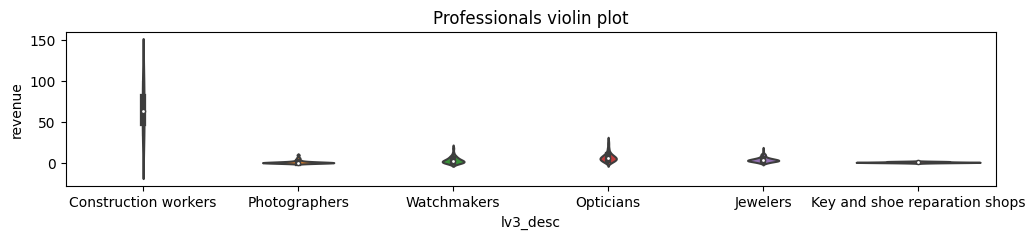

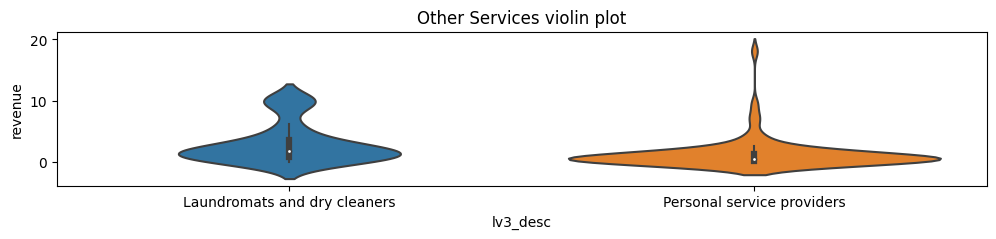

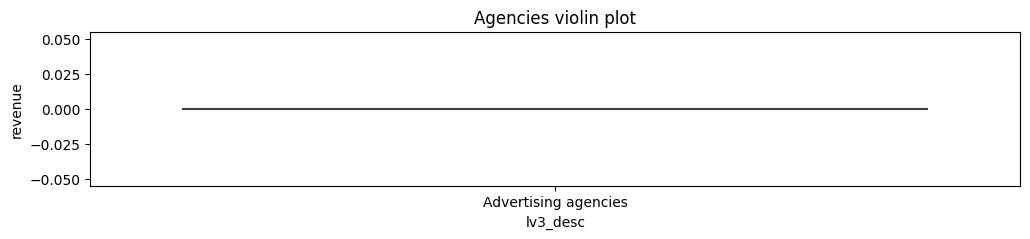

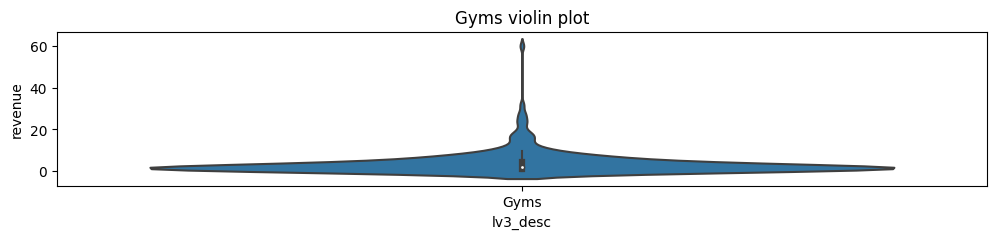

In [21]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

Remove-outliers-function for the relationship between store type and revenue

In [22]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    col_idx = stores.columns.get_loc('revenue')
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        #stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
        
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index,[col_idx]] = upper_treshold
        stores.iloc[stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index,[col_idx]] = lower_treshold
        
    

In [23]:
stores_train = pd.read_csv('data/stores_train.csv')
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


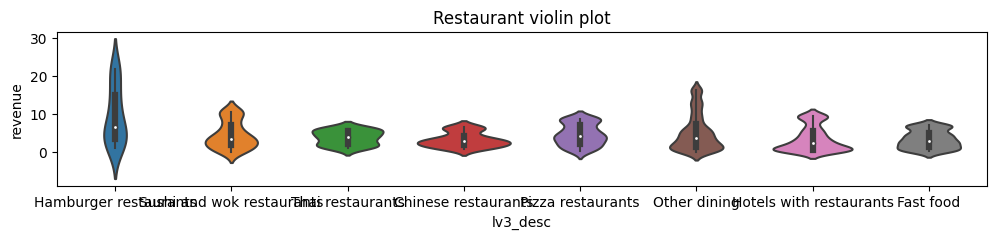

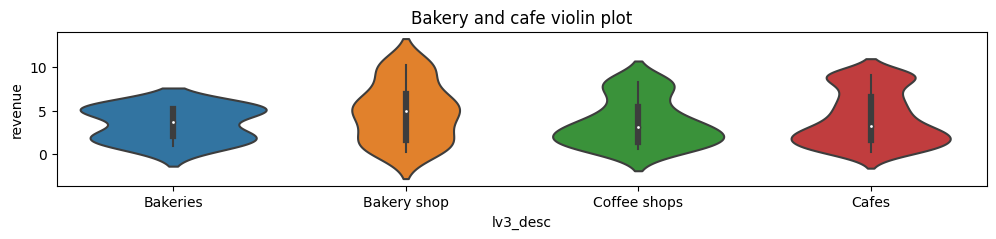

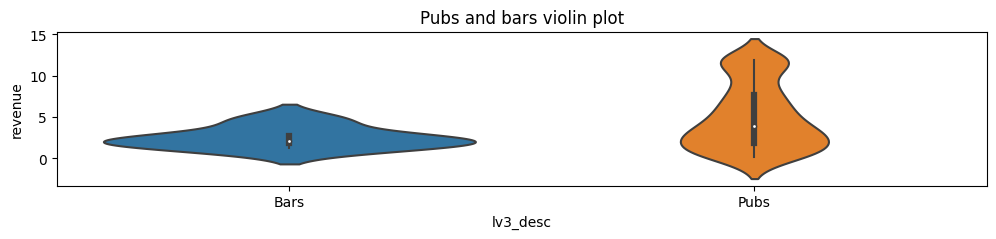

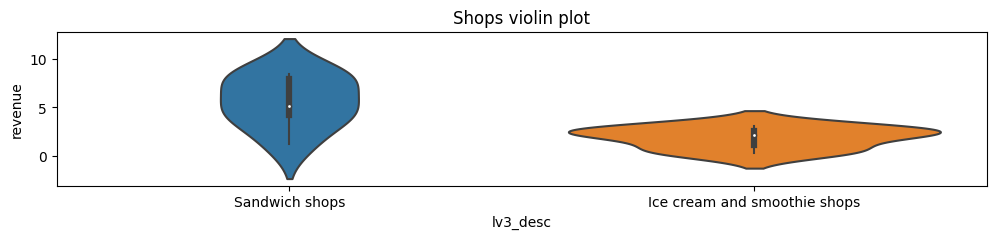

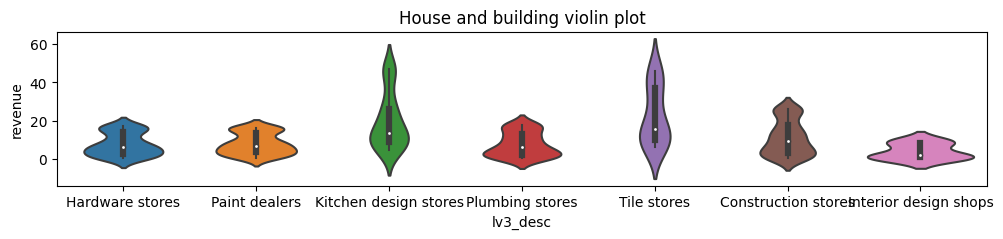

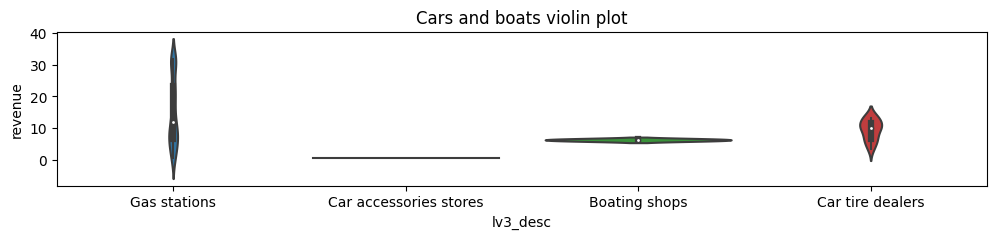

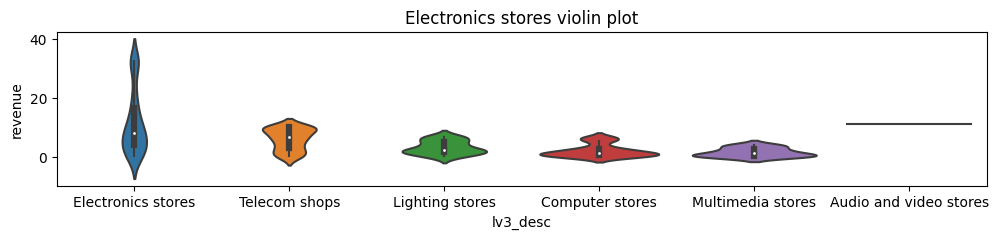

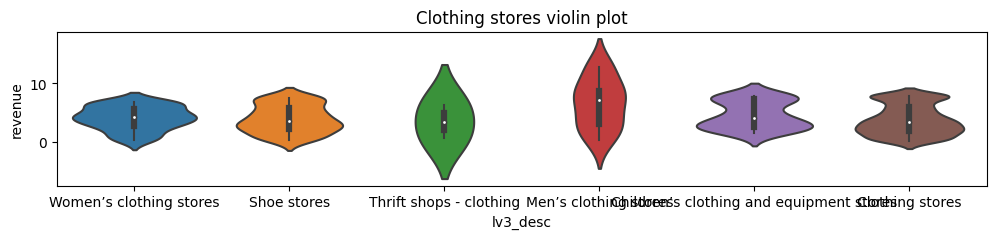

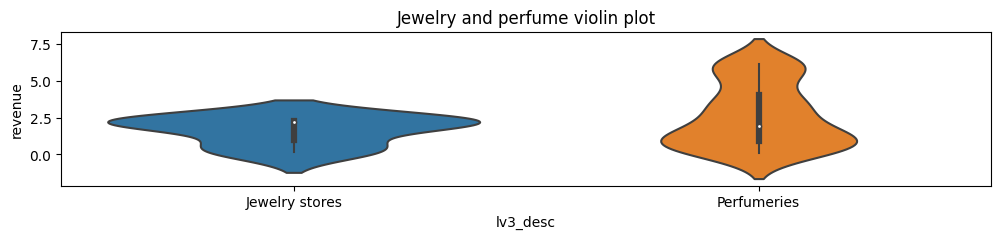

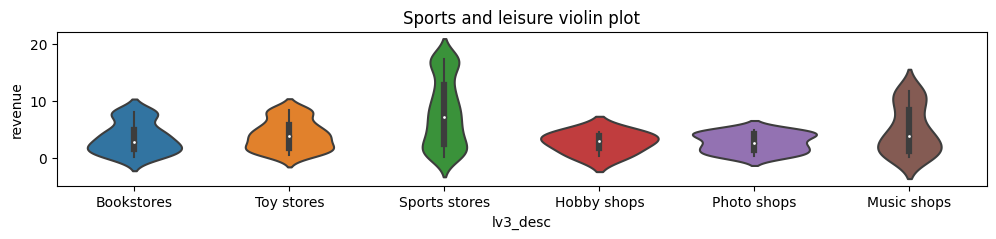

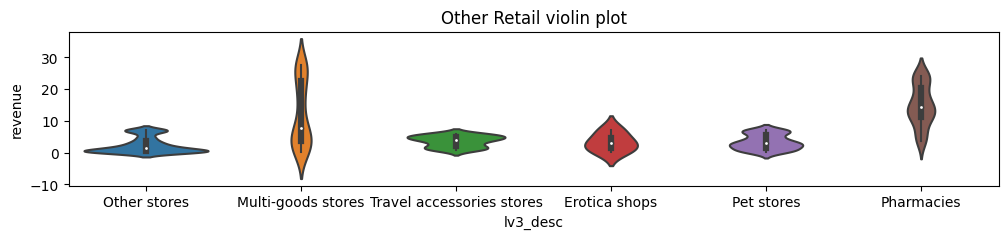

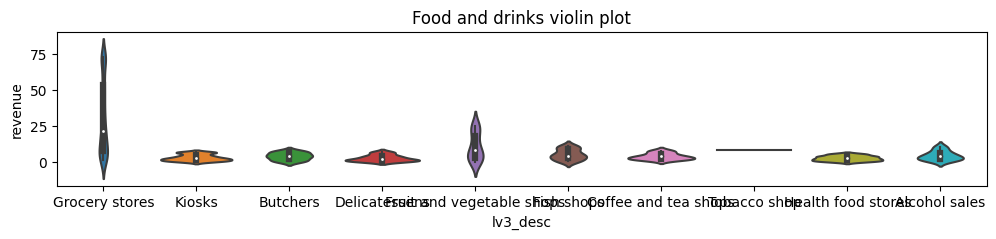

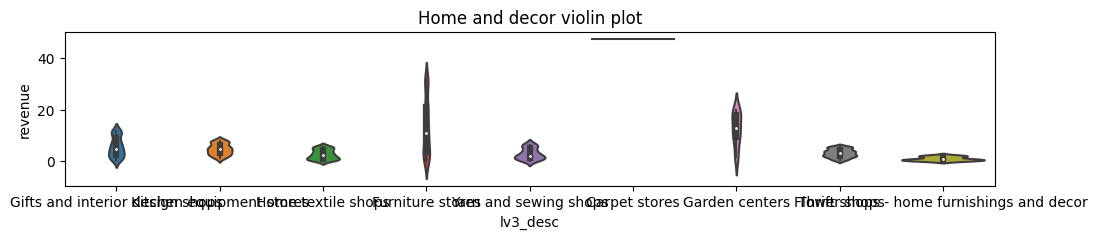

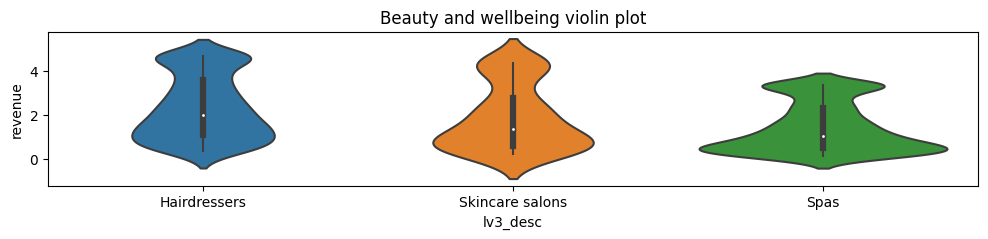

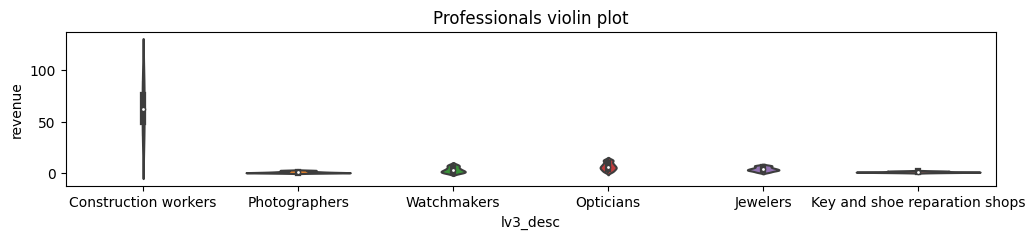

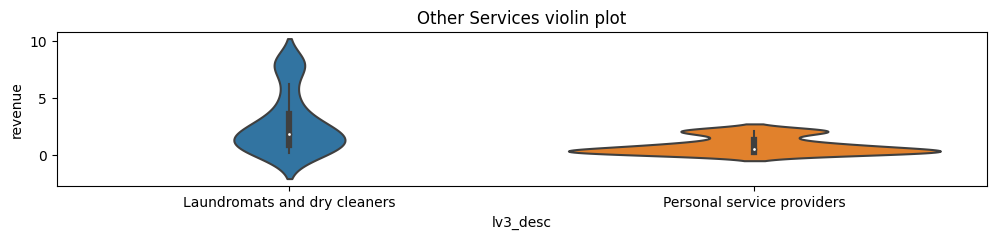

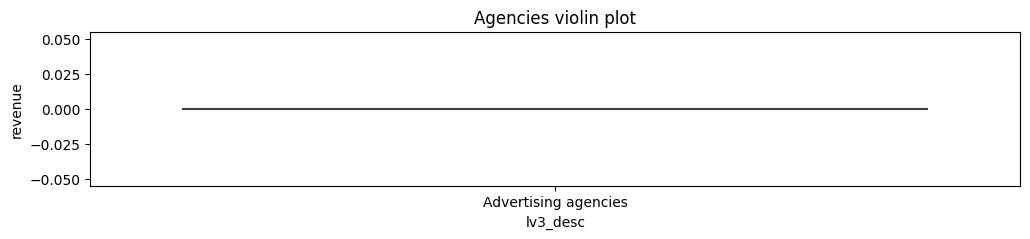

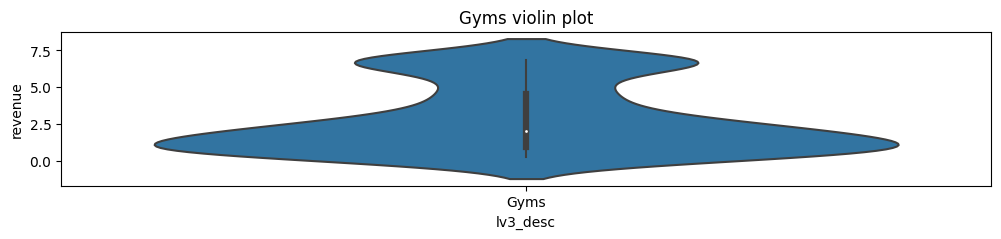

In [24]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

#### comparing test set to training set

In [25]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

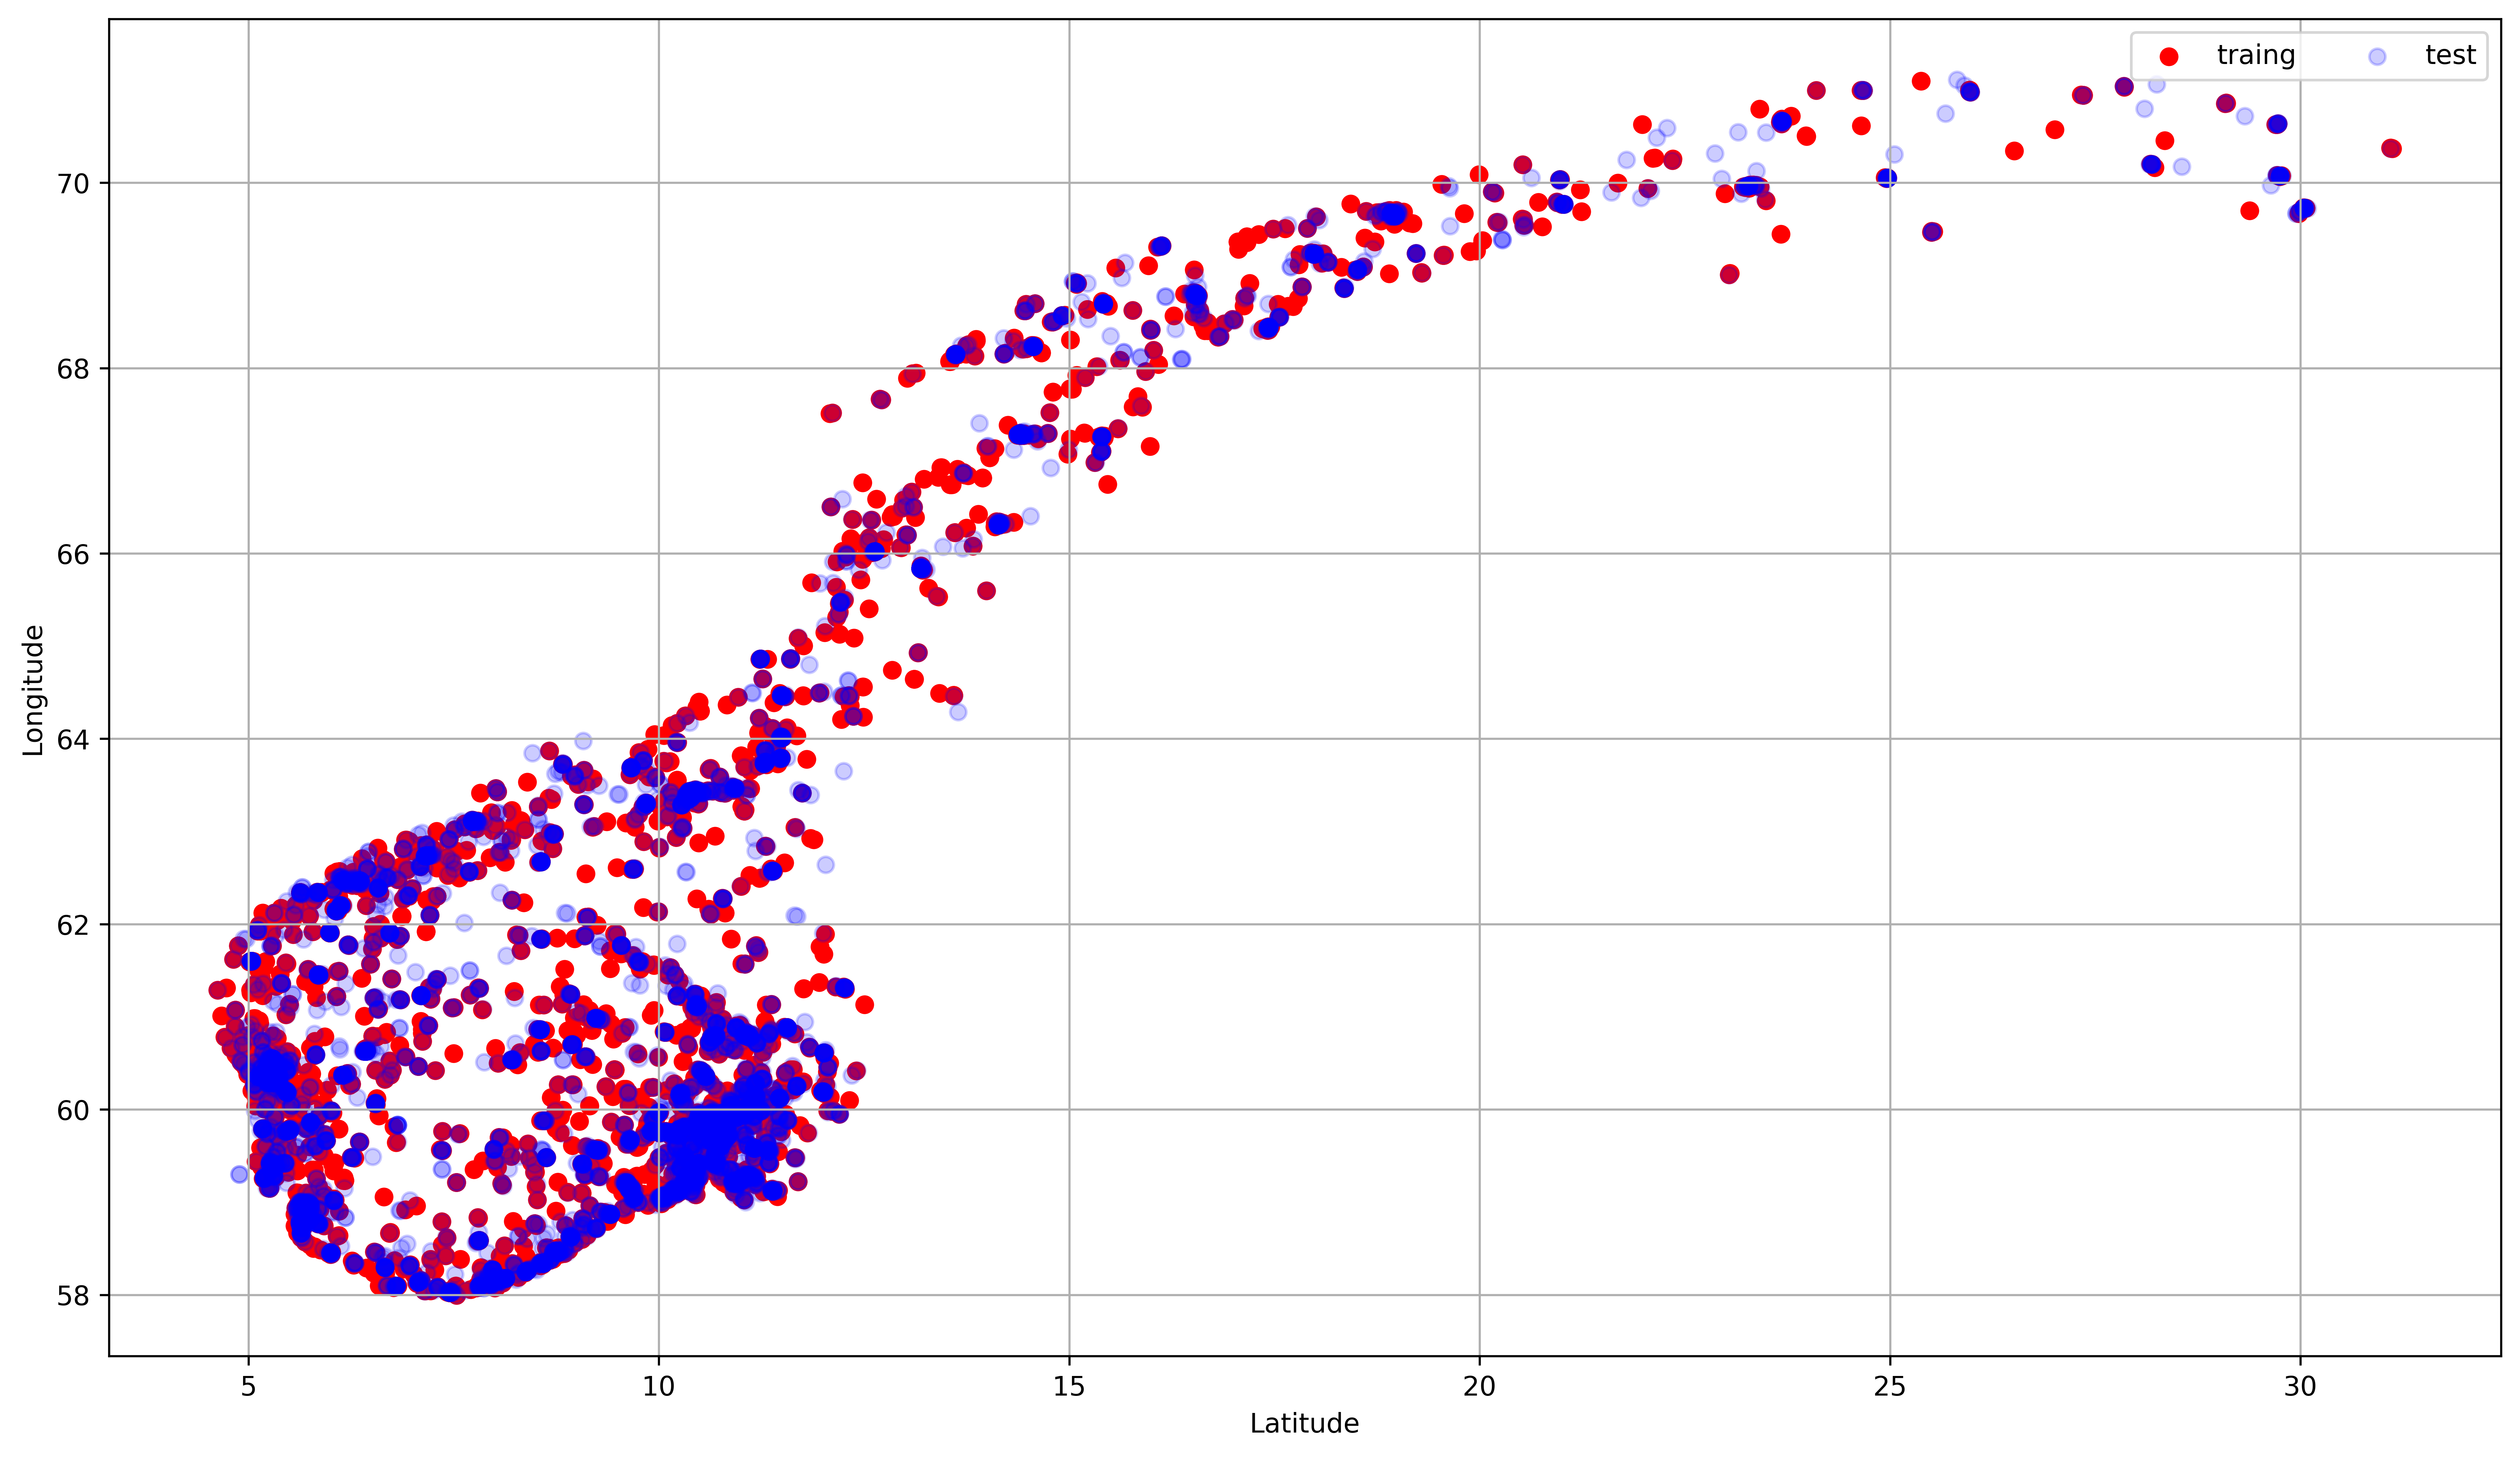

In [26]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



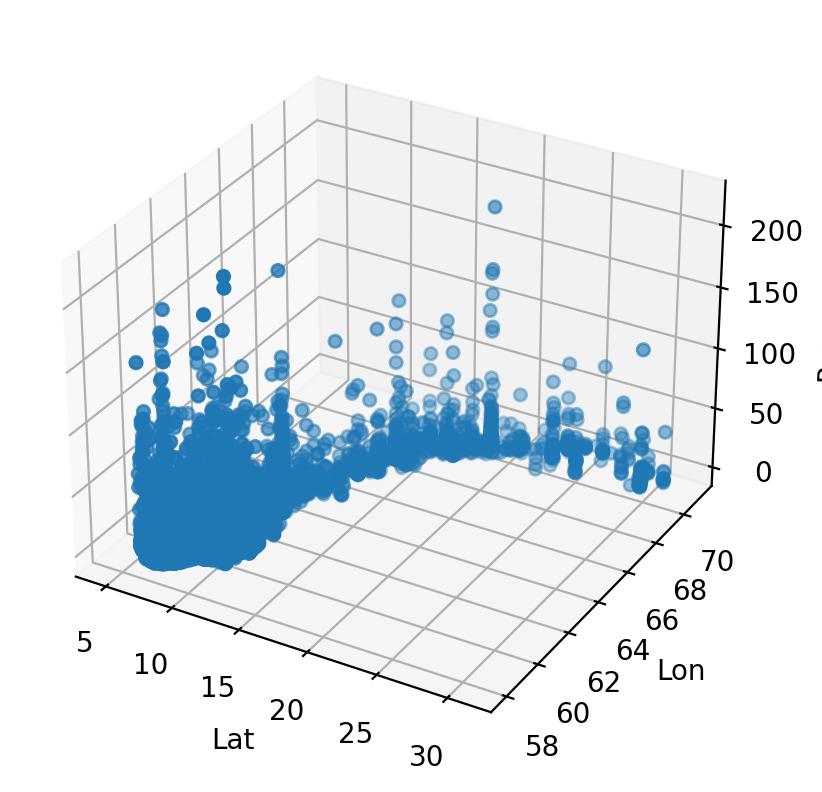

In [27]:
fig = plt.figure(dpi=200)
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lon'],stores_train['lat'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [28]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.head()

store_id_x  year_x         store_name  \
0   988143294-888170332-16561    2016         YAYAS OSLO   
1  994905953-994946978-500374    2016         YAYAS OSLO   
2   913243730-871762422-46032    2016    MING RESTAURANT   
3  913594053-913748263-697094    2016   ALLEGRO PIZZERIA   
4    981126610-981131126-5363    2016  SPISERIET TRIADEN   

  plaace_hierarchy_id_x sales_channel_name_x  grunnkrets_id_x  \
0               1.1.3.0     Thai restaurants          3010905   
1               1.1.3.0     Thai restaurants          3010905   
2               1.1.4.0  Chinese restaurants          5010602   
3               1.1.5.0    Pizza restaurants         19021405   
4               1.1.6.2          Restaurants          2300312   

              address_x      lat_x      lon_x chain_name_x  ... year_y  \
0       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
1       INDUSTRIGATA 36  59.926040  10.719687     CONSELTO  ...   2016   
2          STORGATA 130  61.120842  10.461641          NaN  ...   2016   
3     SOLSTRANDVEGEN 47  69.639962  18.970862          NaN  ...   2016   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195          NaN  ...   2016   

  plaace_hierarchy_id_y  sales_channel_name_y grunnkrets_id_y  \
0               1.1.3.0      Thai restaurants         3010301   
1               1.1.3.0      Thai restaurants         3010301   
2               1.1.4.0   Chinese restaurants         1040504   
3               1.1.5.0     Pizza restaurants        19021404   
4               1.1.6.2           Restaurants         2300312   

              address_y      lat_y      lon_y  chain_name_y  \
0   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
1   MUNKEDAMSVEIEN 53 B  59.910977  10.722538      CONSELTO   
2   DRONNINGENS GATE 27  59.435418  10.659777           NaN   
3        TURISTVEGEN 19  69.646103  18.991212           NaN   
4  ISAK H. WIIKS GATE 3  59.919147  10.952195           NaN   

                    mall_name_y revenue  
0                           NaN   9.233  
1                           NaN   9.233  
2                           NaN   6.484  
3                           NaN   4.609  
4  Triaden Lørenskog Storsenter   5.147  

[5 rows x 22 columns]

### Explore the other data sets

In [29]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                             NaN   
3  d9cda2c7-355a-49c1-b56c-a33180d2a82e                             NaN   
4  f803bcd3-182d-450b-bbb4-113c6ca885c2                             NaN   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   
3  Mangler viktighetsnivå     MIDDLE_LEFT   
4  Mangler viktighetsnivå    MIDDLE_RIGHT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)  
3  POINT(10.7781496457324 59.9301044643692)  
4  POINT(10.7781676444854 59.9302099995898)

In [30]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

grunnkrets_id  year     grunnkrets_name          district_name  \
0       10010701  2015      Grim-Dueknipen  Grim-Møllevann-Dalane   
1       10010803  2015  Kvadraturen sørøst         Kvadraturen-Eg   
2       10020608  2015            Ormestad                  Holum   
3       10020901  2015              Tregde        Tregde-Skjernøy   
4       10030210  2015           Bryneheia             Vanse/Åpta   

  municipality_name                                           geometry  \
0      Kristiansand  MULTIPOLYGON(((7.97199691121304 58.14336769560...   
1      Kristiansand  POLYGON((8.00234207061135 58.1443514886041, 8....   
2            Mandal  POLYGON((7.48512808482995 58.0374976883392, 7....   
3            Mandal  MULTIPOLYGON(((7.50996051810658 58.02134863868...   
4           Farsund  POLYGON((6.70396719073296 58.0877854965615, 6....   

   area_km2  
0  0.768961  
1  0.361355  
2  0.280188  
3  0.156311  
4  0.791894

In [31]:
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_incomes.head()

grunnkrets_id  year  all_households  singles  couple_without_children  \
0       14200105  2016          551700   270300                        0   
1        2311202  2015          577700   311800                        0   
2        2310501  2015          668800   292500                        0   
3       14200401  2016          507000   250700                        0   
4       14200105  2015          539900   275800                        0   

   couple_with_children  other_households  single_parent_with_children  
0                     0                 0                            0  
1                682300                 0                            0  
2                842000                 0                            0  
3                     0                 0                            0  
4                710300                 0                            0

In [32]:
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_households.head()

grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  
0        4  
1        3  
2        7  
3        0  
4        4

In [33]:
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
gk_ages.head()

grunnkrets_id  year  age_0  age_1  age_2  age_3  age_4  age_5  age_6  \
0       16013117  2015     14     14     14     14     13     13     12   
1       16013117  2016     10     10     10     10     10     10      9   
2       11030206  2015      5      5      5      5      5      4      4   
3       16011203  2016      2      2      2      2      2      3      3   
4        3011601  2016      7      7      7      7      6      6      5   

   age_7  ...  age_81  age_82  age_83  age_84  age_85  age_86  age_87  age_88  \
0     11  ...       0       0       0       0       0       0       0       0   
1      9  ...       0       0       0       0       0       0       0       0   
2      3  ...       0       0       0       0       0       0       0       0   
3      3  ...       1       1       1       1       1       1       1       0   
4      4  ...       1       1       0       0       0       0       0       0   

   age_89  age_90  
0       0       0  
1       0       0  
2       0       0  
3       0       0  
4       0       0  

[5 rows x 93 columns]

# ___________ _2. Feature Engineering_ ___________

In [43]:
stores_train = pd.read_csv('data/stores_train.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
gk_incomes = pd.read_csv('data/grunnkrets_income_households.csv')
gk_households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
gk_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
buss_stopps = pd.read_csv('data/busstops_norway.csv')

grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_incomes.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_households.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
gk_ages.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
buss_stopps.drop_duplicates(subset=['busstop_id'], inplace=True)



Ages

In [35]:
# number of people in grunnkrets

# people density (number of people divided by arekm2)

Households

In [46]:
# Number of house holds
gk_households['nb_households']  = np.sum(gk_households.iloc[:,np.arange(2,10,1)], axis=1)
gk_households.head()




grunnkrets_id  year  couple_children_0_to_5_years  \
0       12010509  2015                             0   
1       14390206  2015                             0   
2       18040514  2015                            10   
3       18040804  2015                             0   
4       18200101  2015                             0   

   couple_children_18_or_above  couple_children_6_to_17_years  \
0                            0                              4   
1                            7                              0   
2                            0                              0   
3                            0                              0   
4                            6                              0   

   couple_without_children  single_parent_children_0_to_5_years  \
0                        0                                    0   
1                        0                                    0   
2                        0                                    0   
3                        0                                    0   
4                        0                                    0   

   single_parent_children_18_or_above  single_parent_children_6_to_17_years  \
0                                   0                                     0   
1                                   0                                     0   
2                                   0                                     0   
3                                   0                                     0   
4                                   0                                     0   

   singles  nb_households  
0        4              8  
1        3             10  
2        7             17  
3        0              0  
4        4             10

Buss stops

In [37]:
# Number of buss stops

# distance to buss stop

Train set

In [38]:
# has mall

# has chain

# Distance to another store

# Distance to another store of same type

# Density of stores in grunnkrets

Concat columns

In [44]:
def add_selected_columns(df):
    gk = grunnkrets[['grunnkrets_id','municipality_name']]
    gk_i = gk_incomes[['grunnkrets_id','all_households']] #all house holds = median income
    gk_h = gk_households[['grunnkrets_id','nb_households']]
    gk_a = gk_ages[['grunnkrets_id']]
    
    concat = pd.merge(df, gk, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_i, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_h, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, gk_a, how='left', on='grunnkrets_id')
    
    return concat

# ___________ _3. Machine Learning Models and Predictions_ ___________


### Helper functions

In [40]:
def convert_DType_LGBM(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
            
        #elif dFrame[col_name].dtypes == np.float64:
        #    X[col_name] = dFrame[col_name].astype(np.float64)
            
        else:
            X[col_name] = dFrame[col_name]
    
    return X

## _____ LightGBM _____

In [47]:
stores_train = pd.read_csv('data/stores_train.csv')

# select prefered columns
remove_columns(stores_train, ['store_id','store_name','year','address'])

# Add features
print(stores_train.shape)
stores_train = add_selected_columns(stores_train)
print(stores_train.shape)

# Preprocess/Clean data
#quantile_storeType_vs_revenue(stores_train,0.01, 0.88)

# Divide data into train and test set
x_train = stores_train.drop('revenue', axis=1)

y_train = stores_train['revenue']
#y_train=np.log1p(y_train)

# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=3)


(12859, 8)
(12859, 11)


In [48]:
x_train.dtypes

plaace_hierarchy_id    category
sales_channel_name     category
grunnkrets_id             int64
lat                     float64
lon                     float64
chain_name             category
mall_name              category
municipality_name      category
all_households          float64
nb_households           float64
dtype: object

Make model, train and test


In [49]:
# Make model, tune params and fit training data
# Params obtained trough testing and reading up on this guide: https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
parameters = {
              #'metric': 'acc',
              #'n_estimators' : 400
              #'path_smooth' : 0.5,
              #'min_data_in_leaf' : 3
             }

LGBM_model = LGBMRegressor(**parameters)
LGBM_model.fit(x_train, y_train)
pred = LGBM_model.predict(x_test)
#pred=np.expm1(pred)

number_of_negatives = 0
for i in range(len(pred)):
    if pred[i] < 0.0:
        number_of_negatives += 1
        pred[i] = 0.0

print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,pred)}")

number of negatives: 3
rmsle: 0.7951490543236571


In [ ]:
# Previous rmse scores gave the following kaggle scores:
# - 0.6299535721949822 rmsle resulted in: 0.74549 on kaggle - LGBM_01_88_precentile_allCols_districtName_allHouseHolds_someSmoothin_tuesday (random state = 1)
# - 0.6907625425656421 rmsle resulted in: 0.73635 on kaggle - LGBM_01_88_precentile_allCols_no_other_cols_someSmoothin_tuesday (random state 1)

Predict test and submit

In [57]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
test = stores_test.copy()

# select prefered columns
remove_columns(stores_train, ['store_id','store_name','year', 'address'])
remove_columns(test, ['store_id','store_name','year', 'address'])

# Add features
print(stores_train.shape, test.shape)
stores_train = add_selected_columns(stores_train)
test = add_selected_columns(test)
print(stores_train.shape, test.shape)

# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.01, 0.88)

# Divide data into train and test set
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
y_train=np.log1p(y_train)


# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
test = convert_DType_LGBM(test)
print(x_train.shape, test.shape)

(12859, 8) (8577, 7)
(12859, 11) (8577, 10)
(12859, 10) (8577, 10)


In [58]:
# Model, fit and predict
LGBM_model =LGBMRegressor(**parameters)
LGBM_model.fit(x_train, y_train)
submission_pred = LGBM_model.predict(test)
submission_pred=np.expm1(submission_pred)
# remove negative values
number_of_negatives = 0
for i in range(len(submission_pred)):
    if submission_pred[i] < 0.0:
        number_of_negatives += 1
        submission_pred[i] = 0.0
print(f"number of negatives: {number_of_negatives}")

number of negatives: 0


In [ ]:
#write the predicition to file
writeResultToFile(stores_test, submission_pred, "LGBM_01_88_precentile_allCols_no_other_cols_NoHyperparamTuning_tuesday_npLog")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/LGBM_01_88_precentile_allCols_no_other_cols_NoHyperparamTuning_tuesday_npLog.csv')
submissionVery.info()

## _____ Random Forest Regressor _____

Load, preprocess and convert data to correct format

In [ ]:
# Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])



In [ ]:
stores_train.head()

Train model

In [ ]:
# Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train)


Test RFR model

In [ ]:
# predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train))

Predict test and submit

In [ ]:
pred_test_RFR = RFR.predict(x_test)

In [ ]:
# Write to file
#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
#submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
#submissionVery.info()

## Emil modeller

### model 1


In [ ]:
# pythons stuff emil

# 4. Model Interpretations


learning_rate                    : 0.02
num_leaves                       : 129
colsample_bytree                 : 0.9641318006527376
subsample                        : 0.6378777984991955
verbosity                        : -1
random_state                     : 42
objective                        : regression
metric                           : l2
num_threads                      : 6
reg_alpha                        : 1.3150907339015326e-05
min_sum_hessian_in_leaf          : 0.037391352091827645
reg_lambda                       : 0.001687565277635497
n_estimators                     : 164


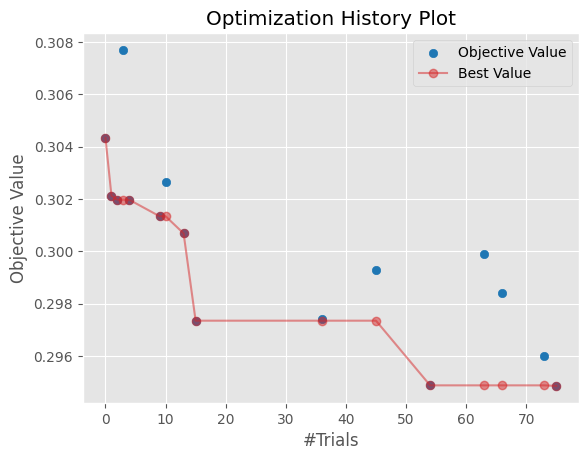

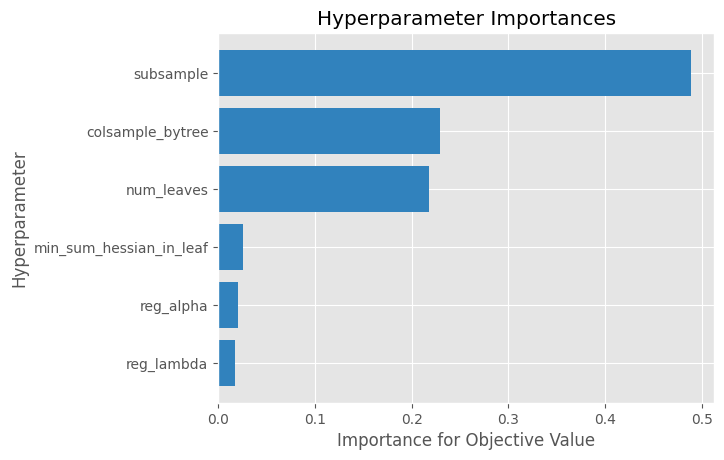

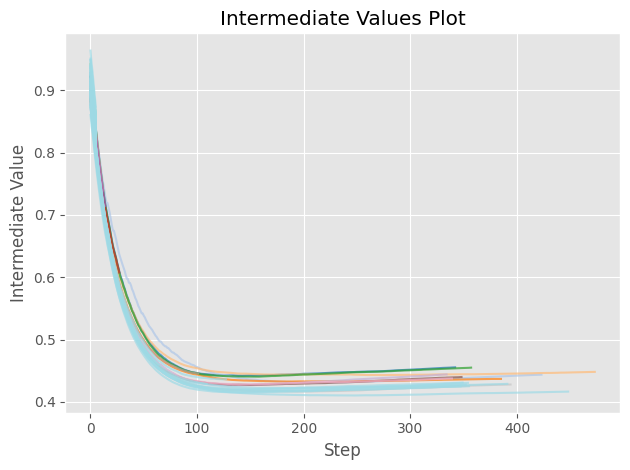

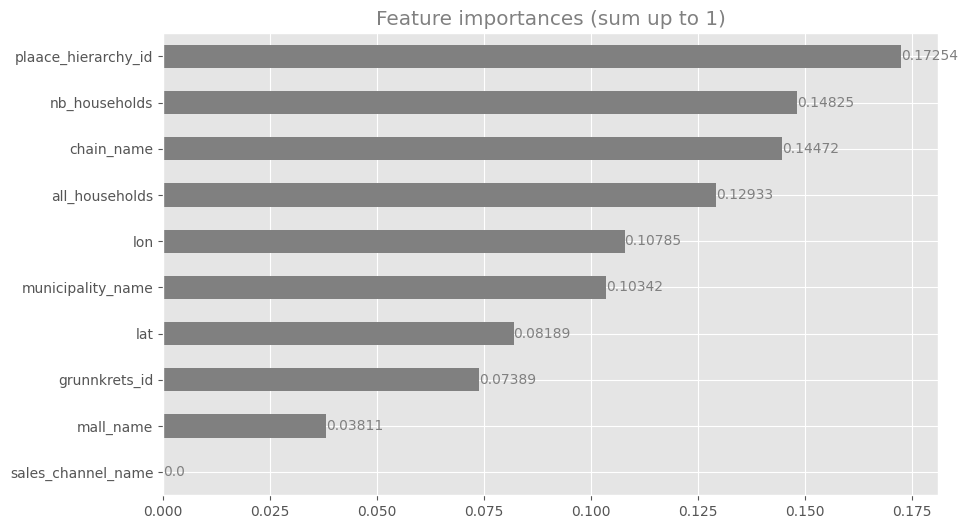



Time elapsed for fit execution: 1 min 39.031 sec


In [65]:
cat_columns = x_train.select_dtypes(['category']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])

# Tune
tuner = LGBMTuner(metric = 'rmsle', verbosity=0)
tuner.fit(x_train, y_train)



### Lime

In [ ]:
#lime stuff in python

### Feature importance

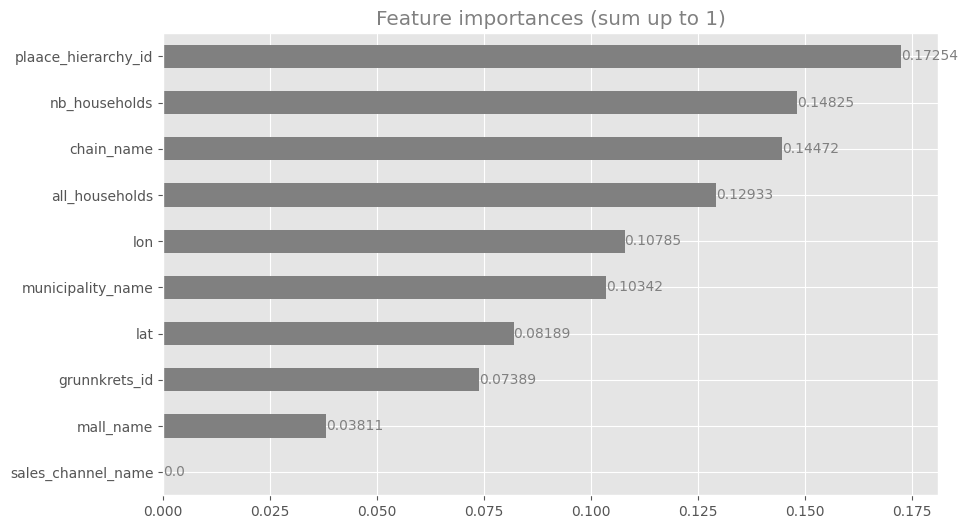

In [66]:
#feature importance

tuner.plot_importances()


### PDP

In [ ]:
#PDP

# 5. Final improved models/predictions

### model 1

In [ ]:
#final model 1

### model 2

In [ ]:
#final model 2

# Testing


#### RMSLE

In [ ]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
